In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

## Iterative Classification for Missing Value Imputation
#### Author: Carl Schneck

One of the first steps of every data science project is handling missing values. The number of missing values and possible entries differ with each problem resulting in different approaches being taken. These approaches include deletion, imputing central tendencies like the mean for non-discrete features, most frequent entry, or random imputation of existing values. Though what if you wanted a less random approach that used the other features to fill in your missing values. This notebook will walk you through why you may want to use an iterative classification approach to filling in missing values instead of the other more common methods. 

The data used for this analysis will be a 2009 survey conducted for the H1N1 outbreak. This survey was performed by the CDC in order to monitor and evaluate the flu vaccination efforts of adults and children in randomly selected US households. The questions asked of the participants dealt with their H1N1 vaccination status, flu-related behaviors, opinions about flu vaccine safety and effectivenss, recent respiratory illness, and pneumococcal vaccination status <a href="#About the National Immunization Survery">[1]</a>.

The following data from the survey can be found and downloaded <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/data/">here</a><a href="#Source Data Download">[2]</a> with feature descriptions found <a href="https://github.com/cschneck7/Iterative_Classification_Blog/blob/main/data/H1N1_and_Seasonal_Flu_Vaccines_Feature_Information.txt">here</a>.

In [2]:
# Import survey data into dataframes
# The source dataset already had this split feature and target files
X = pd.read_csv('data/source_data/training_set_features.csv')
y = pd.read_csv('data/source_data/training_set_labels.csv')

There are originally two different target variable, for this example we will only concentrate on `h1n1_vaccine`.

In [3]:
# Sets target variable
y = y.h1n1_vaccine

Quick look at feature dataframe shape.

In [4]:
# Returns shape of feature dataframe
X.shape

(26707, 36)

Quick look at missing values in feature dataframe.

In [5]:
# Checks amount of Nan values in feature dataframe
missing_values = X.isna().sum()
missing_values

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

## Most Frequent Entry Imputation

Below we observe the normalized distribution of a feature missing only a few entries and one containing many missed entries. We will use these two features to observe how using most frequent entry imputation is good for features that are almost complete though creates a bias for features missing most entries. This bias is very noticable if the original distribution is almost evenly spread, while less severe and possibly usable at distributions that are very far apart.

In [6]:
# Takes both a feature with little and many missing entries
X_missing = X[['behavioral_face_mask', 'health_insurance']]

# Displays number of missing values as well as normalized
# value distribution of existing values in percentages
print(f'Number of missing values: {X_missing.behavioral_face_mask.isna().sum()}')
print(X_missing.behavioral_face_mask.value_counts(normalize=True))
print(f'Number of missing values: {X_missing.health_insurance.isna().sum()}')
print(X_missing.health_insurance.value_counts(normalize=True))

Number of missing values: 19
0.0    0.931018
1.0    0.068982
Name: behavioral_face_mask, dtype: float64
Number of missing values: 12274
1.0    0.87972
0.0    0.12028
Name: health_insurance, dtype: float64


Imputing the most frequent entry using SimpleImputer then analyzing the new distributions.

In [7]:
# Creating a simple imputer object with strategy of most_frequent
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# creates dataframe of transformed features
X_most_frequent = pd.DataFrame(data=si.fit_transform(X_missing),
                               index=X_missing.index,
                               columns=X_missing.columns)


# Displays new value distributions after imputation
print(f'Number of missing values: {X_most_frequent.behavioral_face_mask.isna().sum()}')
print(X_most_frequent.behavioral_face_mask.value_counts(normalize=True))
print(f'Number of missing values: {X_most_frequent.health_insurance.isna().sum()}')
print(X_most_frequent.health_insurance.value_counts(normalize=True))

Number of missing values: 0
0.0    0.931067
1.0    0.068933
Name: behavioral_face_mask, dtype: float64
Number of missing values: 0
1.0    0.934998
0.0    0.065002
Name: health_insurance, dtype: float64


As can be seen above this imputation method barely changed the distribution of values for `behavioural_face_mask` which was only missing 19 entries. On the other hand the feature `health_insurance` which was missing nearly half its values had its distibution spread increase by nearly 11%. Even though there was already a mismatched distribution the most frequent entry imputation method created a larger bias in value distribution.

## Random Imputation

Next we will take a quick look at random imputation. This method randomly imputes values based of the existing values distribution. This may already be more attractive than the previous method because it ensures the distribution will stay constant. We'll use the same values as before to provide an example.

In [8]:
# Creates copy of DataFrame
X_rand_imp = X_missing.copy()

# Iterates through features
for col in X_missing.columns:
#     Finds number of missing values in feature
    number_missing = X_rand_imp[col].isnull().sum()
#     Finds normalized distribution of existing entries
    value_dist = X_rand_imp.loc[X_rand_imp[col].notnull(), col].value_counts(normalize=True)
#     Sets random seed for random.choice
    np.random.seed(0)
#     Randomly Imputes observed values replacing all missing information
    X_rand_imp.loc[X_rand_imp[col].isnull(), col] = np.random.choice(value_dist.index, 
                                                                     number_missing, 
                                                                     replace = True,
                                                                     p = value_dist)
    
# Displays before and after imputation distributions
print('behavioral_face_mask\n')
print(f'Original Distribution:\nNumber of missing values: {X_missing.behavioral_face_mask.isna().sum()}')
print(X_missing.behavioral_face_mask.value_counts(normalize=True))
print(f'\nDistribution after random imputation:\nNumber of missing values: {X_rand_imp.behavioral_face_mask.isna().sum()}')
print(X_rand_imp.behavioral_face_mask.value_counts(normalize=True))
print('\n-------------------------------------------------------------\n')
print('health_insurance\n')
print(f'Original Distribution:\nNumber of missing values: {X_missing.health_insurance.isna().sum()}')
print(X_missing.health_insurance.value_counts(normalize=True))
print(f'\nDistribution after random imputation:\nNumber of missing values: {X_rand_imp.health_insurance.isna().sum()}')
print(X_rand_imp.health_insurance.value_counts(normalize=True))

behavioral_face_mask

Original Distribution:
Number of missing values: 19
0.0    0.931018
1.0    0.068982
Name: behavioral_face_mask, dtype: float64

Distribution after random imputation:
Number of missing values: 0
0.0    0.931029
1.0    0.068971
Name: behavioral_face_mask, dtype: float64

-------------------------------------------------------------

health_insurance

Original Distribution:
Number of missing values: 12274
1.0    0.87972
0.0    0.12028
Name: health_insurance, dtype: float64

Distribution after random imputation:
Number of missing values: 0
1.0    0.879957
0.0    0.120043
Name: health_insurance, dtype: float64


As seen above this method maintains the original distribution of values after imputation. It should be noted that while this method maintains the distribution of the original feature, the accuracy of imputed entries drops in comparison to the most frequent entry imputation approach. If you assume the missing entries follow the same distribution as the original, by imputing the most frequent entry the accuracy will be equal to the distribution of that most frequent entry in the original data. For example if the distribution is 80:20 for existing values, the accuracy of most frequent entry imputation will be 80%. While the accuracy of using the above random imputation method is only 68%. This can be found by considering of the 80% of values randomly imputed as the most frequent value, only 80% of them will be correct and vice versa for the less frequent value. The accuracy for random imputation is calculated below for this example.

In [9]:
100*((.8*.8) + (.2*.2))

68.00000000000001

Now what if you had a feature similar to the H1N1 survey. Some features have many missing values so most frequent entry imputation would not work there. Also random imputation may not be ideal because of the lower accuracy as well as the random aspect. Why not try a method that will use the other features to help predict what these missing values could be. Atleast that was my mentality while working on this project, therefore I went searching for a model to fit my case. I had one issue that had to be handled prior to trying to classify my features. This was the different amount of missing values present in the features and in different entry locations. Any classification model won't work if it's features have NaN values, thus these need to be sorted prior to modeling. I wasn't sure exactly how to handle this but found an <a href="https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression">article</a> written by Shashanka Subrahmanya were he uses regression to fill in missing values <a href='#Missing Data Imputation using Regression'>[3]</a>. In Shashanka's article he utilizes random imputation prior to creating his model to then attempt to predict those missing values therefore I took the same approach. I took it a step further though and created my own class with a fit and transform methods in order to save the value distributions if a training and test split is being used.

## Random Imputation Class Creation

I start my RandomImputer class by inheriting the properties of `BaseEstimator` and `TransformerMixin`. The initialization of the class can take one argument `missing_columns`. This argument can be used to specify which columns are to have random imputation performed on them. If left to the default value any column with a missing value will be performed on.

Next the `fit` method is created, since this class is a transformer only the feature DataFrame is required as an argument and `y` is set equal to `None`. In the `fit` method the columns to be transformed are will be assigned if they weren't specified in the initialization. The value distributions are then saved in a dictionary and saved as a parameter to be utilized in the transform method.

Next is the transform method. In the transform method, values are randomly imputed in the locations with missing values. New columns are created to signal that these columns have imputed data. The original columns with missing values are not removed because they are later used in the Iterative Classification model to locate where the missing values were located. Returned is a DataFrame containing the passed columns to the transformer as well as new columns with the randomly imputed values.


In [10]:
class RandomImputer(BaseEstimator, TransformerMixin):
    '''
    Randomly imputes values for missing data in new columns.
    Values are based off of existing values and rates of occurences.
    
    Initialized with optional argument columns which specify
    columns to be transformed, if left to default value 'all_missing_columns', all
    columns with missing values will be filled.
    '''
    
#     Initializes class object
    def __init__(self, missing_columns='all_missing_columns'):
        self.missing_columns = missing_columns
 

    def fit(self, X, y=None):
#     Finds column names containing missing values if missing_columns equals all_missing_columns
        if self.missing_columns == 'all_missing_columns':
            nan_amount = X.isna().sum()
            self.missing_columns = list(nan_amount[nan_amount>0].index)
#     Handles if single column entered as string
#     str type changed to list for future for loop operation
        elif type(self.missing_columns) == str:
            self.missing_columns = [self.missing_columns]

#     Initializes empty dict which will contain distribution of existing values for columns
#     in missing_columns
        feature_value_info = {}
#     Iterates through missing_columns finding value distributions 
        for col in self.missing_columns:
            feature_value_info[col] = X.loc[X[col].notnull(), col].value_counts(normalize=True)

#     Saves distributions as parameter
        self.feature_value_info = feature_value_info
        return self
            
    
    def transform(self, X, y=None):
#         Sets random seed for random seed generation for iterative
#         calls to random.choice in for loop
        np.random.seed(7337)
#         random seeds generation for loop
        rand_seeds = np.random.randint(0, 10e3, len(self.missing_columns), 'int64')
        
        df = X.copy()
        
#     Iterates through missing columns
        for i, col in enumerate(self.missing_columns):
#     Creates copy of column to have values imputed into
            df[col+'_imp'] = df[col]
#     Finds number of missing values in column
            number_missing = df[col].isnull().sum()
#     Sets random seed for random.choice
            np.random.seed(rand_seeds[i])
#     Randomly Imputes observed values replacing all missing information
            df.loc[df[col].isnull(), col+'_imp'] = np.random.choice(self.feature_value_info[col].index, 
                                                                    number_missing, 
                                                                    replace = True,
                                                                    p = self.feature_value_info[col])

#     Creates column index variable to be called to set DataFrame index
        self.features_out = df.columns
        
        return df
    
#     Returns final columns index
    def get_features_out(self):
        return self.features_out

Let's apply this transformer to the dataset and observe the results. First we need to perform some feature preparation that includes encoding our object columns and dropping `respondent_id` which doesn't supply any useful information. We'll also create a train-test split in order to later evaluate our results.

In [24]:
# Drops id column
X_mod = X.drop('respondent_id', axis=1)

# Creates train test split
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, random_state=42, test_size=.25)

# Creates dataframe of object types
X_train_obj_feat = X_train.select_dtypes(include='object').copy()

# Creates dataframe non object features
X_train_num_feat = X_train.select_dtypes(exclude='object').copy()

# Initialized ordinal encoder object
oe = OrdinalEncoder()

# Creates dataframe of ordinal encoded data
X_train_enc_obj = pd.DataFrame(data = oe.fit_transform(X_train_obj_feat),
                         columns=X_train_obj_feat.columns,
                         index=X_train_obj_feat.index)

# Combines encoded object features with non-object features
X_train_enc = pd.concat([X_train_enc_obj, X_train_num_feat], axis=1)

Now that are object features are encoded we can now move on to the random imputation transformer.

In [25]:
# Creates class object
ri = RandomImputer()

# Fits and transforms dataset
X_train_imp = ri.fit_transform(X_train_enc)

print('Missing values:')
# checks if all columns besides original columns with missing data are filled in
X_train_imp.drop(ri.missing_columns, axis=1).isna().sum()

Missing values:


age_group                          0
race                               0
sex                                0
hhs_geo_region                     0
census_msa                         0
education_imp                      0
income_poverty_imp                 0
marital_status_imp                 0
rent_or_own_imp                    0
employment_status_imp              0
employment_industry_imp            0
employment_occupation_imp          0
h1n1_concern_imp                   0
h1n1_knowledge_imp                 0
behavioral_antiviral_meds_imp      0
behavioral_avoidance_imp           0
behavioral_face_mask_imp           0
behavioral_wash_hands_imp          0
behavioral_large_gatherings_imp    0
behavioral_outside_home_imp        0
behavioral_touch_face_imp          0
doctor_recc_h1n1_imp               0
doctor_recc_seasonal_imp           0
chronic_med_condition_imp          0
child_under_6_months_imp           0
health_worker_imp                  0
health_insurance_imp               0
o

We have now filled all missing values using random imputation. In the next blog we will use an iterative classification class to impute the missing values based off of the feature content.

## Iterative Classification Method

Next we'll take a look at the iterative classifier. Similarly to the random imputation a class was created to prevent data leakage in case a train and test split is being utilized. The classifier works by iterating through the features and creating a separate Decision Tree model at each step. During each step, one feature is determined as the dependent variable and the rest are the independent variables. These are then used to fit a Decision Tree Classifier. This model is then used to predict values to replace those that were randomly imputed using the RandomImputer class. The next iteration then utilizes these newly predicted values to build the model for the next feature. This is then repeated until all features with missing values have had models created for them as dependent variables.

### Initialization

The IterativeClassification class is initialized with four possible arguments:

1. `max_depth` to define the depth of the DecisionTreeClassifiers.
2. `class_order` determining the order that features are classified in. Currently the two available options are `many_first` and `less_first`. The `many_first` option will classify features in descending order of missing values in the feature, while `less_first` is in ascending order.
3. `num_cols` contains list of numerical features
4. `cat_cols` contains list of categorical features.

The arguments `num_cols` and `cat_cols` are required in order to encode our categorical features using the OneHotEncoder before each iterations modeling process.

### Helper Methods

The class has two helper methods `_imp_columns` and `_step_features`.

#### `_imp_columns`

This helper method takes a list of feature names and adds the `_imp` extension to them if they had previously had values imputed for their missing values using the RandomImputer transformer. This is mainly used to set the list of independent variable names for each iteration.

#### `_step_features`

This method is used to return the current iterations independent variables. It takes two arguments, `X` which is the feature DataFrame and `col` which is the current iterations target variable. It then utilizes the `_imp_columns` function to create a list of the proper feature names for both categorical and numerical features assigned by the `cat_cols` and `num_cols` parameters. The features are then sorted and categorical features one hot encoded. The sorting is to prevent errors occurring in calculations using the decision tree classifier.

### `fit` Method
 
The `fit` method is called with a single argument `X` which is the feature DataFrame. This DataFrame can even contain the original problems target variable to help predict the remaining missing values. The method starts out by creating a list of columns that had missing values before the RandomImputer transformer was used. This list is sorted in either descending or ascending order by quantity of missing values depending on the parameter `class_order` and is saved as the parameter `missing_columns`. 

Next the remaining features that had no missing values are found, sorted and saved to the parameter `leftover_features`. 

Utilizing list comprehension the extension `_imp` is added to the features present in `missing_columns`. This list is combined with the list of features in `leftover_features` and saved to the parameter `pred_features` which will be used to make a slice of `X` containing all the features to be used in creating the iterative decision tree models. This slice called `pred_df` now contains the columns with the randomly imputed data and the features that didn't initially contain any missing data. 

Next two empty dictionaries are initiated to contain each iterations Decision Tree Classification model as well as that iterations accuracy. The accuracy is calculated using the values that weren't missing compared to their predicted values. The features contained in `missing_colunns` are then iterated through, setting the current feature as the target variable. The `_step_features` helper method is used to create each iterations independent variable dataframe. A decision tree classification model is then fit to this iterations data and saved to the `models` dictionary. Before moving to the next iteration the `pred_df` is updated to replace the current iterations target variables randomly imputed values with predicted values using the decision tree classifier. An accuracy score is then calculated and added to the `accuracy_scores` dictionary. Once all the features contained in `missing_columns` have been iterated through the two dictionaries are saved as parameters and `self` is returned to complete the `fit` method.

### `transform` Method

The `transform` method starts by creating a new holder DataFrame that will contain the original and predicted values called `det_df`. The DataFrame is initialized to contain the feature names contained in the parameter `missing_columns` with `Det_` added to the front of each name. This is to signify that this feature has been modified using the IterativeClassification transformer. Then similarly to the `fit` method each feature included in the parameter `missing_columns` is iterated through. In each iteration the helper method `_step_features` is used create the current encoded feature DataFrame. This DataFrame is then used to predict and replace the randomly imputed values using this iterations decision tree model from the `fit` method.  An accuracy score is also calculated at each iteration similarly to the method in the fit method. After all iterations are finished, the final DataFrame with all randomly imputed values replaced with predicted values is returned.


In [17]:
class IterativeClassification(BaseEstimator, TransformerMixin):
    '''
    Uses an iterative DecisionTreeClassifier to fill in missing values.
    
    __init__ :
        Input: max_depth = max_depth parameter of DecisionTreeClassifier
               class_order = 'many_first' or 'less_first'
                             default = 'many_first', determines which order
                             or columns to iterate through based off of quantity
                             of missing values in columns
               num_cols = columns with numerical data
               cat_cols = columns with categorical data to be one hot encoded
    
    fit : 
        Input: X = DataFrame with missing values
               y = None
               
    transform :
        Input: X = DataFrame with missing values to be transformed
        
    get_features_out :
        Returns column names for final transformed DataFrame
    '''
    
    def __init__(self, max_depth=None, class_order='many_first', num_cols=None, cat_cols=None):
        self.max_depth=max_depth
        self.class_order=class_order
        self.num_cols=num_cols
        self.cat_cols=cat_cols

    def fit(self, X, y=None):
        '''
        Iteratively fits DecisionTreeClassifier models to pd.DataFrame X
        
        1. Sorts columns with missing values by quantity, the order set
        by argument class_order with options 'many_first' and 'less_first'.
        
        2. Finds the leftover features that didn't have any missing values
        and don't need to be classified from DataFrame X, sorts these to prevent
        indexing issues later on.
        
        3 Creates a list of all features being used to fit the 
        DecisionTreeClassifier, input DataFrame X should be in a format resulting
        from being tranformed using the RandomImputer tranformer. The features 
        resulting from this transformer have had variables randomly imputed and 
        the feature names ending with '_imp' to signify their transformation. 
        The input DataFrame X contains all the features from the original DataFrame
        with missing values plus the imputed features.
        
        4. Creates a DataFrame copy using the list from step 3.
        
        5. Iterates through the columns that had missing values,
        using their imputed copy as a target variable and the rest of 
        the features from the DataFrame created in step 4 to fit a 
        DecisionTreeClassifier. The remaining features have to be 
        OneHotEncoded before used in Classifier. This classifier is then 
        used to predict the variables for those that were originally 
        missing and replacing them in the DataFrame created in step 4.
        
        The fifth step is then repeated for each column while saving the 
        DecisionTreeClassifier at each step to be used later in the 
        transform method.
        '''
        
#         Finds amount of nans in columns
#         Orders columns to be predicted by class_order argument
        nan_amount = X.isna().sum()
        if self.class_order == 'many_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values(ascending=False).index)
        elif self.class_order == 'less_first':
            self.missing_columns = list(nan_amount[nan_amount>0].sort_values().index)
        else:
            sys.exit('''Incorrect input for class_order argument.
                 Argument only accepts values ('many_first', or 'less_first')''')

#         Finds features in dataframe that aren't included in missing_columns
        leftover_features = list(set(X.columns) - set(self.missing_columns) - 
                                {col+'_imp' for col in self.missing_columns})
        leftover_features.sort()
        self.leftover_features = leftover_features
        
#         Sets missing_columns predictive features with _imp extension matching fitting from RandomImputer class
#         Adds leftover features to create dataframe with all predictive features
        self.pred_features = [col+'_imp' for col in self.missing_columns] + leftover_features
        pred_df = X[self.pred_features].copy()
        
#         Creates empty dictionairies for fitted models, and their accuracy scores
        models = {}
        accuracy_scores = {}
        
#         Iterates through missing_columns, creating a model, updating feature with predicted values
#         at each iteration
        for col in self.missing_columns:
#             creates dataframe for this iterations predictives features
#             This involves ohe categorical features
            temp_df = self._step_features(pred_df, col)
#             Initializes and fits DecisionTreeClassifier
            dt = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
            dt.fit(temp_df, pred_df[col+'_imp'])
            
#             imports predicted values into missing locations
            pred_df.loc[X[col].isnull(), col+'_imp'] = dt.predict(temp_df)[X[col].isnull()]
            
#             Saves this iterations model and accuracy score
            models[col] = dt
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                dt.predict(temp_df)[X[col].notnull()])    
        self.dt_models = models
        self.fit_accuracy_scores = accuracy_scores
        
        return self
    
    
    def transform(self, X, y=None):
        '''
        Transforms X using models fit in fit method
        
        1. Creates prediction df with all columns that will be classified
        
        2. Iterates through the columns with missing values in the same manner
           as the fit method, except only tranforming the target using the
           fitted classifiers from the fit method.
           
        3. Creates Final DataFrame containing classified columns, plus columns
           that weren't originally missing values
        '''
#         Initializes dataframe containing determined values
        det_df = pd.DataFrame(columns = ['Det_'+col for col in self.missing_columns])
#         Creates dataframe of predictive features
        pred_df = X[self.pred_features].copy()
        
#         empty dictionary to fill with each iterations accuracy score
        accuracy_scores = {}
            
#         Iterates through missing columns to transform with fitted models
        for col in self.missing_columns:
#             Fills determined column with values
            det_df['Det_'+col] = X[col+'_imp']
#             creates dataframe for this iterations predictives features
#             This involves ohe categorical features 
            temp_df = self._step_features(pred_df, col)
#             Loads this iterations fitted model
            dt_model = self.dt_models[col]
#            imports predicted values into missing locations for predictive and determined dataframe
            det_df.loc[X[col].isnull(), 'Det_'+col] = dt_model.predict(temp_df)[X[col].isnull()]
            pred_df.loc[X[col].isnull(), col+'_imp'] = dt_model.predict(temp_df)[X[col].isnull()]
        
#             Saves this iterations accuracy score
            accuracy_scores[col] = accuracy_score(X.loc[X[col].notnull(), col],
                                                  dt_model.predict(temp_df)[X[col].notnull()])  

#         Creates transformed df determined features as well as nontransformed features
        final_df = pd.concat([det_df, X[self.leftover_features]], axis=1)
        
#         Saves transformed models feature names and accuracy scores       
        self.features_out = final_df.columns
        self.transform_accuracy_scores = accuracy_scores
    
        return final_df
    
#     Returns transformed models feature names
    def get_features_out(self):
        return self.features_out
    
#     Creates dataframe for the current iteration
    def _step_features(self, X, col):
        '''
        Takes current iterations target variable, and creates
        independent variable dataframe with proper feature names 
        and OneHotEncodes categorical columns
        
        inputs: X = feature dataframe
                col = Current iterations target variable
                
        output: DataFrame with OneHotEncoded categorical features
                and correct feature names matching those from the
                RandomImputer class
        '''
#         Checks if categorical features exist
        if self.cat_cols != None:
#             adds _imp to end of feature name if included in missing_columns
            imp_cat_cols = self._imp_columns(self.cat_cols)
#             creates list of columns to be OneHotEncoded
            ohe_cols = list(set(imp_cat_cols) - {col+'_imp'})
#             Sorts in alphabetical order for consistency
            ohe_cols.sort()
#             Initializes, fits and transforms OneHotEncoder
            ohe = OneHotEncoder(sparse=False) 
            ohe_features = ohe.fit_transform(X[ohe_cols])
#             Creates dataframe with OneHotEncoded features
            ohe_df = pd.DataFrame(ohe_features,
                        columns=ohe.get_feature_names_out(ohe_cols),
                        index=X.index)
#             Checks if there are numerical columns    
            if self.num_cols != None:
#                 adds _imp to end of feature name if included in missing_columns
                imp_num_cols = self._imp_columns(self.num_cols)
#                 Creates list of numerical column names and sorts them
                num_columns = list(set(imp_num_cols) - {col+'_imp'})
                num_columns.sort()
#                 creates dataframe with ohe and num features    
                temp_df = pd.concat([X[num_columns], ohe_df], axis=1)
#             Creates dataframe if there are no numerical features
            else:
                temp_df = ohe_df
#         Checks if their are numerical features, if no categorical features            
        elif self.num_cols != None:
#             adds _imp to end of feature name if included in missing_columns
            imp_num_cols = self._imp_columns(self.num_cols)
#             Creates list of numerical column names and sorts them
            num_columns = list(set(imp_num_cols) - {col+'_imp'})
            num_columns.sort()
            
#             creates dataframe with numerical features with altered names
            temp_df = X[num_columns].copy()
#         If no features were assigned to either num_cols or cat_cols
        else: 
            sys.exit('''Need to assign both or one of num_cols and cat_cols''')
            
        return temp_df
    
    def _imp_columns(self, columns):
        '''
        Adds _imp to end of feature name if included in missing_columns.
        missing_columns should be features transformed through the RandomImputer
        class
        
        input: columns = columns to have feature names tranformed if applicable
        ouput: list of new column names
        '''
        imp_cols = [col+'_imp' if col in self.missing_columns else col for col in columns]
        return imp_cols

Now that our `IterativeClassification` transformer is complete, let's check how it works in practice. We'll start by creating lists or the categorical and numerical columns. Then fitting our transformer to our training set.

In [72]:
# categorical feature names
cat_cols = ['race',
            'hhs_geo_region',
            'census_msa',
            'employment_status',
            'household_adults',
            'household_children',
            'education',
            'income_poverty']

# numerical feature names
num_cols = list(set(X.columns) - set(cat_cols) - {'respondent_id'})

# Creates IterativeClassification class object with max_depth = 5
iter_class = IterativeClassification(max_depth=5, cat_cols=cat_cols, num_cols=num_cols)

# fits transformer to training dataset
X_train_prep = iter_class.fit_transform(X_train_imp)

Let's now prepare our test set similarly to our training set and then transform it using our `IterativeClassification` object.

In [73]:
# Creates dataframe of object types
X_test_obj_feat = X_test.select_dtypes(include='object').copy()
# Creates dataframe of non object features
X_test_num_feat = X_test.select_dtypes(exclude='object').copy()

# Creates dataframe of ordinal encoded data
X_test_enc_obj = pd.DataFrame(data = oe.transform(X_test_obj_feat),
                         columns=X_test_obj_feat.columns,
                         index=X_test_obj_feat.index)

# Combines encoded object features with non-object features
X_test_enc = pd.concat([X_test_enc_obj, X_test_num_feat], axis=1)

# Transforms test dataset
X_test_imp = ri.transform(X_test_enc)

X_test_prep = iter_class.transform(X_test_imp)

With our test set transformed, let's check if our transformer performed better than the other methods. Only the figures will be shown below, the code can be referenced in the repository.

First we'll take a look at the change in most frequent entry distribution changes between the transformed and original datasets.

In [118]:
# creates empty list for metrics of interest
index = []
# Original most frequent entry distribution
orig_most_freq_dist = []
# pre-transform training set most frequent entry distribution
pre_train_freq_dist = []
# pre-transform test set most frequent entry distribution
post_train_freq_dist = []
# post-transform training set most frequent entry distribution
pre_test_freq_dist = []
# post-transform test set most frequent entry distribution
post_test_freq_dist = []
# Estimated accuracy for training set from random imputaiton
estimated_train_rand_imp_acc = []
# Estimated accuracy for test set from random imputaiton
estimated_test_rand_imp_acc = []
# accuracy of IterativeClassification transformer on training set based on existing values
train_acc_score = []
# accuracy of IterativeClassification transformer on test set based on existing values
test_acc_score = []

# iterates through transformed columns and appending metrics
for col in iter_class.missing_columns:
    index.append(col)
    train_acc_score.append(100*iter_class.fit_accuracy_scores[col])
    test_acc_score.append(100*iter_class.transform_accuracy_scores[col])
    orig_most_freq_dist.append(100*round(X[col].value_counts(normalize=True).iloc[0], 3))
    
    pre_train_dist = X_train[col].value_counts(normalize=True)
    pre_train_freq_dist.append(round(pre_train_dist.iloc[0], 3))
    
    pre_test_dist = X_test[col].value_counts(normalize=True)
    pre_test_freq_dist.append(round(pre_test_dist.iloc[0], 3))
    
    post_train_dist = X_train_prep['Det_'+col].value_counts(normalize=True)
    post_train_freq_dist.append(round(post_train_dist.iloc[0], 3))
    
    post_test_dist = X_test_prep['Det_'+col].value_counts(normalize=True)
    post_test_freq_dist.append(round(post_test_dist.iloc[0], 3))
    
    temp_sum = 0
    for dist in pre_train_dist:
        temp_sum+= dist**2
    estimated_train_rand_imp_acc.append(100*round(temp_sum, 3))
    
    temp_sum = 0
    for dist in pre_test_dist:
        temp_sum+= dist**2
    estimated_test_rand_imp_acc.append(100*round(temp_sum, 3))

# Creates dictionary of all metrics
eval_dict = {'orig_most_freq_dist': orig_most_freq_dist,
             'pre_train_freq_dist': pre_train_freq_dist, 
             'post_train_freq_dist': post_train_freq_dist,
             'pre_test_freq_dist': pre_test_freq_dist,
             'post_test_freq_dist': post_test_freq_dist,
             'estimated_train_rand_imp_acc': estimated_train_rand_imp_acc,
             'estimated_test_rand_imp_acc': estimated_test_rand_imp_acc,
             'train_acc_score': train_acc_score,
             'test_acc_score': test_acc_score}

# Creates dataframe containing all metrics
eval_df = pd.DataFrame(data=eval_dict, index=index)
eval_df.head()

,orig_most_freq_dist,pre_train_freq_dist,post_train_freq_dist,pre_test_freq_dist,post_test_freq_dist,estimated_train_rand_imp_acc,estimated_test_rand_imp_acc,train_acc_score,test_acc_score
employment_occupation,13.4,0.132,0.447,0.141,0.452,7.1,7.2,39.483728,39.683023
employment_industry,18.4,0.188,0.487,0.174,0.483,9.0,8.7,39.429196,37.338151
health_insurance,88.0,0.881,0.936,0.875,0.932,79.1,78.2,88.154117,87.513751
income_poverty,57.3,0.577,0.618,0.562,0.613,43.9,42.9,65.962651,65.091436
doctor_recc_h1n1,78.0,0.778,0.786,0.784,0.791,65.5,66.1,85.273172,85.419376


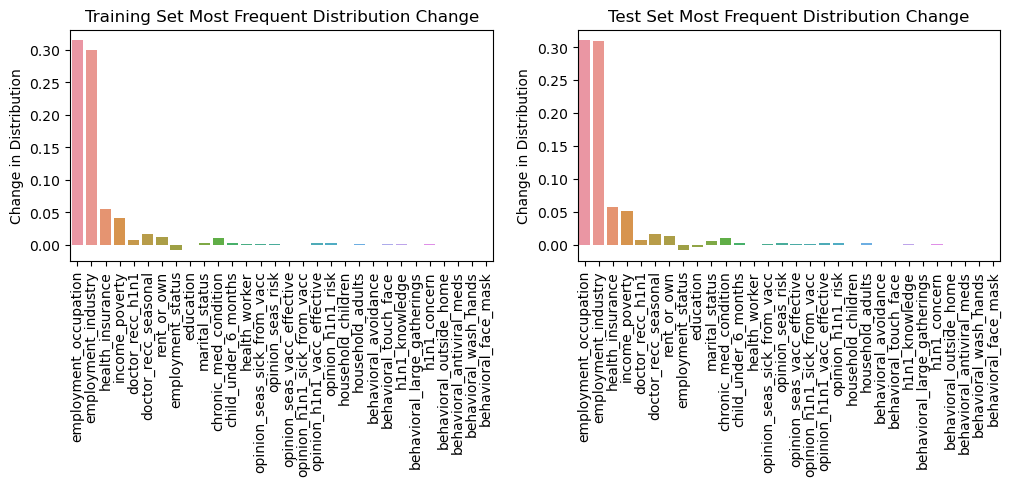

In [117]:
fig, axes = plt.subplots(figsize=(12,3), ncols=2, nrows=1, dpi=100)

sns.barplot(x=eval_df.index, y=(eval_df.post_train_freq_dist-eval_df.pre_train_freq_dist), ax=axes[0]);
axes[0].set_xticklabels(labels=eval_df.index, rotation = 90)
axes[0].set_title('Training Set Most Frequent Distribution Change');
axes[0].set_ylabel('Change in Distribution')

sns.barplot(x=eval_df.index, y=(eval_df.post_test_freq_dist-eval_df.pre_test_freq_dist), ax=axes[1]);
axes[1].set_xticklabels(labels=eval_df.index, rotation = 90)
axes[1].set_title('Test Set Most Frequent Distribution Change');
axes[1].set_ylabel('Change in Distribution')

#     Saves figure
# fig.savefig('images/figures/distibution_change.png', 
#             dpi=100, 
#             bbox_inches="tight",
#             pad_inches=0)

Above shows that most entries barely had a change in distribution. It should be noted that the order of features on the x-axis are in descending order of number of original missing entries. The top two features `employment_occupation` and `employment_industry` also contain many different possible entries, making the accuracy of the RandomImputer very low. These factors will cause our models for those steps to perform poorly. In an actual project the missing values for these features would most likely be filled using another method, or ommited since they are missing most of their entries.

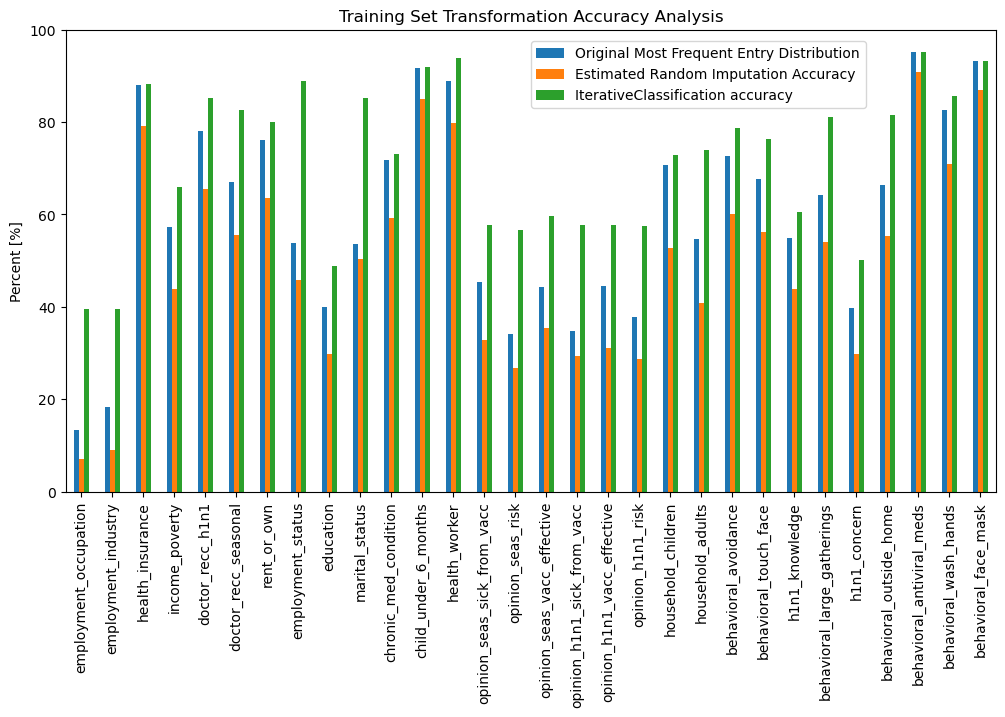

In [128]:
fig, ax = plt.subplots(figsize=(12,6), dpi=100);

eval_df.plot(y=['orig_most_freq_dist', 'estimated_train_rand_imp_acc', 'train_acc_score'], 
             kind='bar', use_index=True, ax=ax);
ax.legend(['Original Most Frequent Entry Distribution', 
           'Estimated Random Imputation Accuracy', 
           'IterativeClassification accuracy'], loc=[.5, .83]);
ax.set_title('Training Set Transformation Accuracy Analysis');
ax.set_ylabel('Percent [%]')

#     Saves figure
# fig.savefig('images/figures/training_accuracy.png', 
#             dpi=100, 
#             bbox_inches="tight",
#             pad_inches=0)

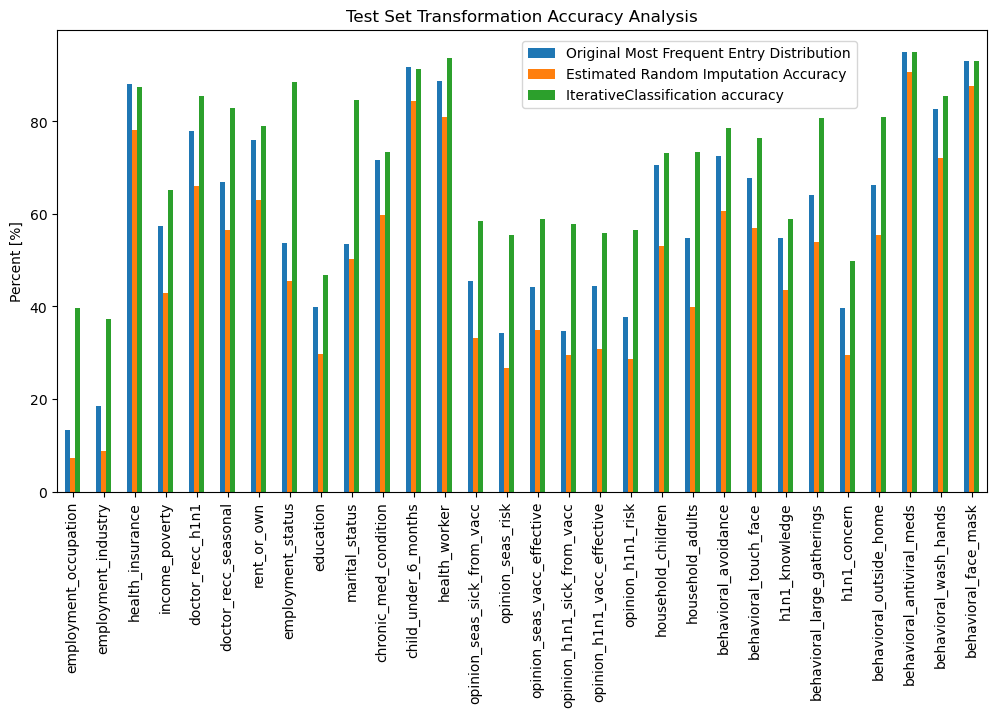

In [129]:
fig, ax = plt.subplots(figsize=(12,6), dpi=100);

eval_df.plot(y=['orig_most_freq_dist', 'estimated_test_rand_imp_acc', 'test_acc_score'], 
             kind='bar', use_index=True, ax=ax);
ax.legend(['Original Most Frequent Entry Distribution', 
           'Estimated Random Imputation Accuracy', 
           'IterativeClassification accuracy'], loc=[.5, .83]);
ax.set_title('Test Set Transformation Accuracy Analysis');
ax.set_ylabel('Percent [%]')

#     Saves figure
# fig.savefig('images/figures/test_accuracy.png', 
#             dpi=100, 
#             bbox_inches="tight",
#             pad_inches=0)

The above figures shows the accuracy when using most freuqent value imputation, estimated random imputation accuracy and the IterativeClassification transformer accuracy for both the training and test sets. The accuracy for the IterativeClassificaiton transformer is calculated by predicted values using the models in the transformer and comparing these results to the entries that had existing values. As can be seen above the accuracy of the IterativeClassification transformer is always more accurate than the estimate random imputation accuracy. While also performing almost identically or better than the most frequent entry imputation for all features except for the `health_insurance` feature in the test set. 

Looking at the results I would be inclined to call the IterativeClassification transformer a success. For the most part it maintained the distribution of features as well as improved on the accuracy of the other common imputation methods. 

## References

[1] <a id='About the National Immunization Survery' href="https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1">https://webarchive.loc.gov/all/20140511031000/http://www.cdc.gov/nchs/nis/about_nis.htm#h1n1</a>

[2] <a href='https://www.drivendata.org/competitions/66/flu-shot-learning/data/'>https://www.drivendata.org/competitions/66/flu-shot-learning/data/</a>

[3] <a id='Missing Data Imputation using Regression' href='https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression'>https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression</a>